
In <a href='https://medium.com/intellectual-explorers-club/memetic-tribes-and-culture-war-2-0-14705c43f6bb' target='_blank'>Memetic Tribes and Culture War 2.0</a>, Peter Limberg and Conor Barnes reference a Google Spreadsheet where they are compiling their data.

<figure name="7247" id="7247" class="graf graf--figure graf--layoutOutsetCenter graf-after--p" data-scroll="native">
    <img src="https://cdn-images-1.medium.com/max/1000/1*k3zWQFbKT51T96AAMdfKdA.png">
    <figcaption class="imageCaption">
        Click <a href="https://docs.google.com/spreadsheets/d/11Ov1Y1xM-LCeYSSBYZ7yPXJah2ldgFX4oIlDtdd7-Qw/edit?usp=sharing" target="_blank">here</a> to view the full chart.
    </figcaption>
</figure>

One of the columns contains lists of records from another column. I am going to convert this into a directed graph using <code>pandas</code> and <code>networkx</code>.

The easiest way to get data out of html tables on the web is to use <code>pandas</code> <code>read_html</code> function, but you have to pick through the tables in the list to see which one contains the data you want.

In [ ]:

%pprint

In [1]:

import pandas as pd

tables_url = r'https://docs.google.com/spreadsheets/d/11Ov1Y1xM-LCeYSSBYZ7yPXJah2ldgFX4oIlDtdd7-Qw'
tribes_df_list = pd.read_html(tables_url)
print(len(tribes_df_list))

2



I had to perform a lot of <a href='https://secure.i.telegraph.co.uk/multimedia/archive/02152/panda-upside-down_2152868i.jpg' target='_blank'>panda gymnastics</a> in order to clean off the husk of the Google table and get the data into a compact space.

In [2]:

tribes_df = tribes_df_list[0].dropna(axis=0, how='all').dropna(axis=1, how='all').iloc[:, 1:]
tribes_df.columns = tribes_df.iloc[0]
tribes_df = tribes_df.iloc[1:].T
tribes_df.columns = tribes_df.iloc[0]
tribes_df = tribes_df.iloc[1:].T
tribes_df.sample(3).T.sample(6).T

,SACRED VALUES,CHIEFTAINS,EXISTENTIAL THREATS,CAMPFIRE,MASTER STATUS,COMBATANTS
MEMETIC TRIBE,,,,,,
MRA (Mens Right Advocates),Gender Equality,"Warren Farrell, Paul Elam",Biased legal system against men,A Voice for Men,Mens Advocate,"SJA, #MeToo, Gender-Critical Feminists"
Modern Neo-Marxists,Class Consciousness,"Douglas Lain, Mark Fisher, Slavoj Zizek",Recuperation,"Student groups, Zero Books, Libcom",Revolutionary,"Establishment Left, Establishment Right"
Black Lives Matter,Restorative Justice,"Alicia Garza, DeRay Mckesson, Ta Nehisi Coates",Systemic racism,"Protests, Campuses, Twitter",African American,"Alt-Lite, Alt-Right, Trumpists, Establishment ..."



It's an easy matter to add the tribes into a directional graph.

In [3]:

import networkx as nx

tribes_digraph = nx.DiGraph()
tribes_digraph.add_nodes_from(tribes_df.T.to_dict())


Next is figuring out, from the combatant lists, where the edges are.

In [4]:

from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

tribe_list = tribes_df.index.tolist()
for row_index, row_value in tribes_df['COMBATANTS'].iteritems():
    combatant_list = row_value.split(', ')
    for combatant in combatant_list:
        if combatant != 'None':
            
            # The combatants are in slightly differing spellings,
            # so I need to just guess which one I mean
            this_tribe = sorted(tribe_list,
                                key=lambda tribe: similar(combatant, tribe.split(' (')[0]))[-1]
            
            tribes_digraph.add_edge(row_index, this_tribe)


I have to use Gephi to get every node away from the other edges because `networkx` doesn't do that well enough.

In [5]:

import os

# Export the graph into Gephi
SAVES_FOLDER = '../saves'
gexf_dir = os.path.join(SAVES_FOLDER, 'gexf')
os.makedirs(name=gexf_dir, exist_ok=True)
file_name = 'tribes_digraph.gexf'
file_path = os.path.join(gexf_dir, file_name)
nx.write_gexf(tribes_digraph, file_path)
message_str = '''
1) Launch Gephi
2) In the File menu, open {}
3) Select and run the Fruchterman Reingold layout
4) Select and run the Label Adjust layout
5) In the File/Export submenu, select Graph file... and save as {}.gdf
6) Repeat 2) through 5) as necessary
'''
print(message_str.format(os.path.abspath(file_path), file_name.split('.')[0]))


1) Launch Gephi
2) In the File menu, open C:\Users\dev\Documents\Repositories\mimetic_tribes\saves\gexf\tribes_digraph.gexf
3) Select and run the Fruchterman Reingold layout
4) Select and run the Label Adjust layout
5) In the File/Export submenu, select Graph file... and save as tribes_digraph.gdf
6) Repeat 2) through 5) as necessary




I have decided to color the mutual combatants' edge red. For this I need a list of edges that have arrows pointing both ways.

In [6]:

full_edge_list = list(tribes_digraph.edges())
double_edge_list = []
while len(full_edge_list) > 0:
    edge_tuple = full_edge_list.pop()
    doubled_tuple = (edge_tuple[1], edge_tuple[0])
    if doubled_tuple in full_edge_list:
        double_edge_list.append(edge_tuple)
        double_edge_list.append(doubled_tuple)

In [7]:

single_edge_list = []
full_edge_list = list(tribes_digraph.edges())
for edge_tuple in full_edge_list:
    if edge_tuple not in double_edge_list:
        single_edge_list.append(edge_tuple)

In [8]:

# Get the positional information that you exported from Gephi
import re
import numpy as np

gdf_folder = os.path.join(SAVES_FOLDER, 'gdf')
os.makedirs(name=gdf_folder, exist_ok=True)
file_path = os.path.join(gdf_folder, 'tribes_digraph.gdf')
search_regex = re.compile(r"""^([^,]+),"\1",([.\d-]+),([.\d-]+),([.\d-]+),([.\d-]+),'([^']+)'(,0)?$""")
tribes_layout_dict = {}
with open(file_path) as file:
    for line in file:
        match_obj = search_regex.search(line)
        if match_obj:
            node_name = match_obj.group(1)
            node_x = match_obj.group(4)
            node_y = match_obj.group(5)
            tribes_layout_dict[node_name] = np.array([float(node_x), float(node_y)])

In [9]:

set(tribes_digraph.nodes()) - set(tribes_layout_dict.keys())

set()

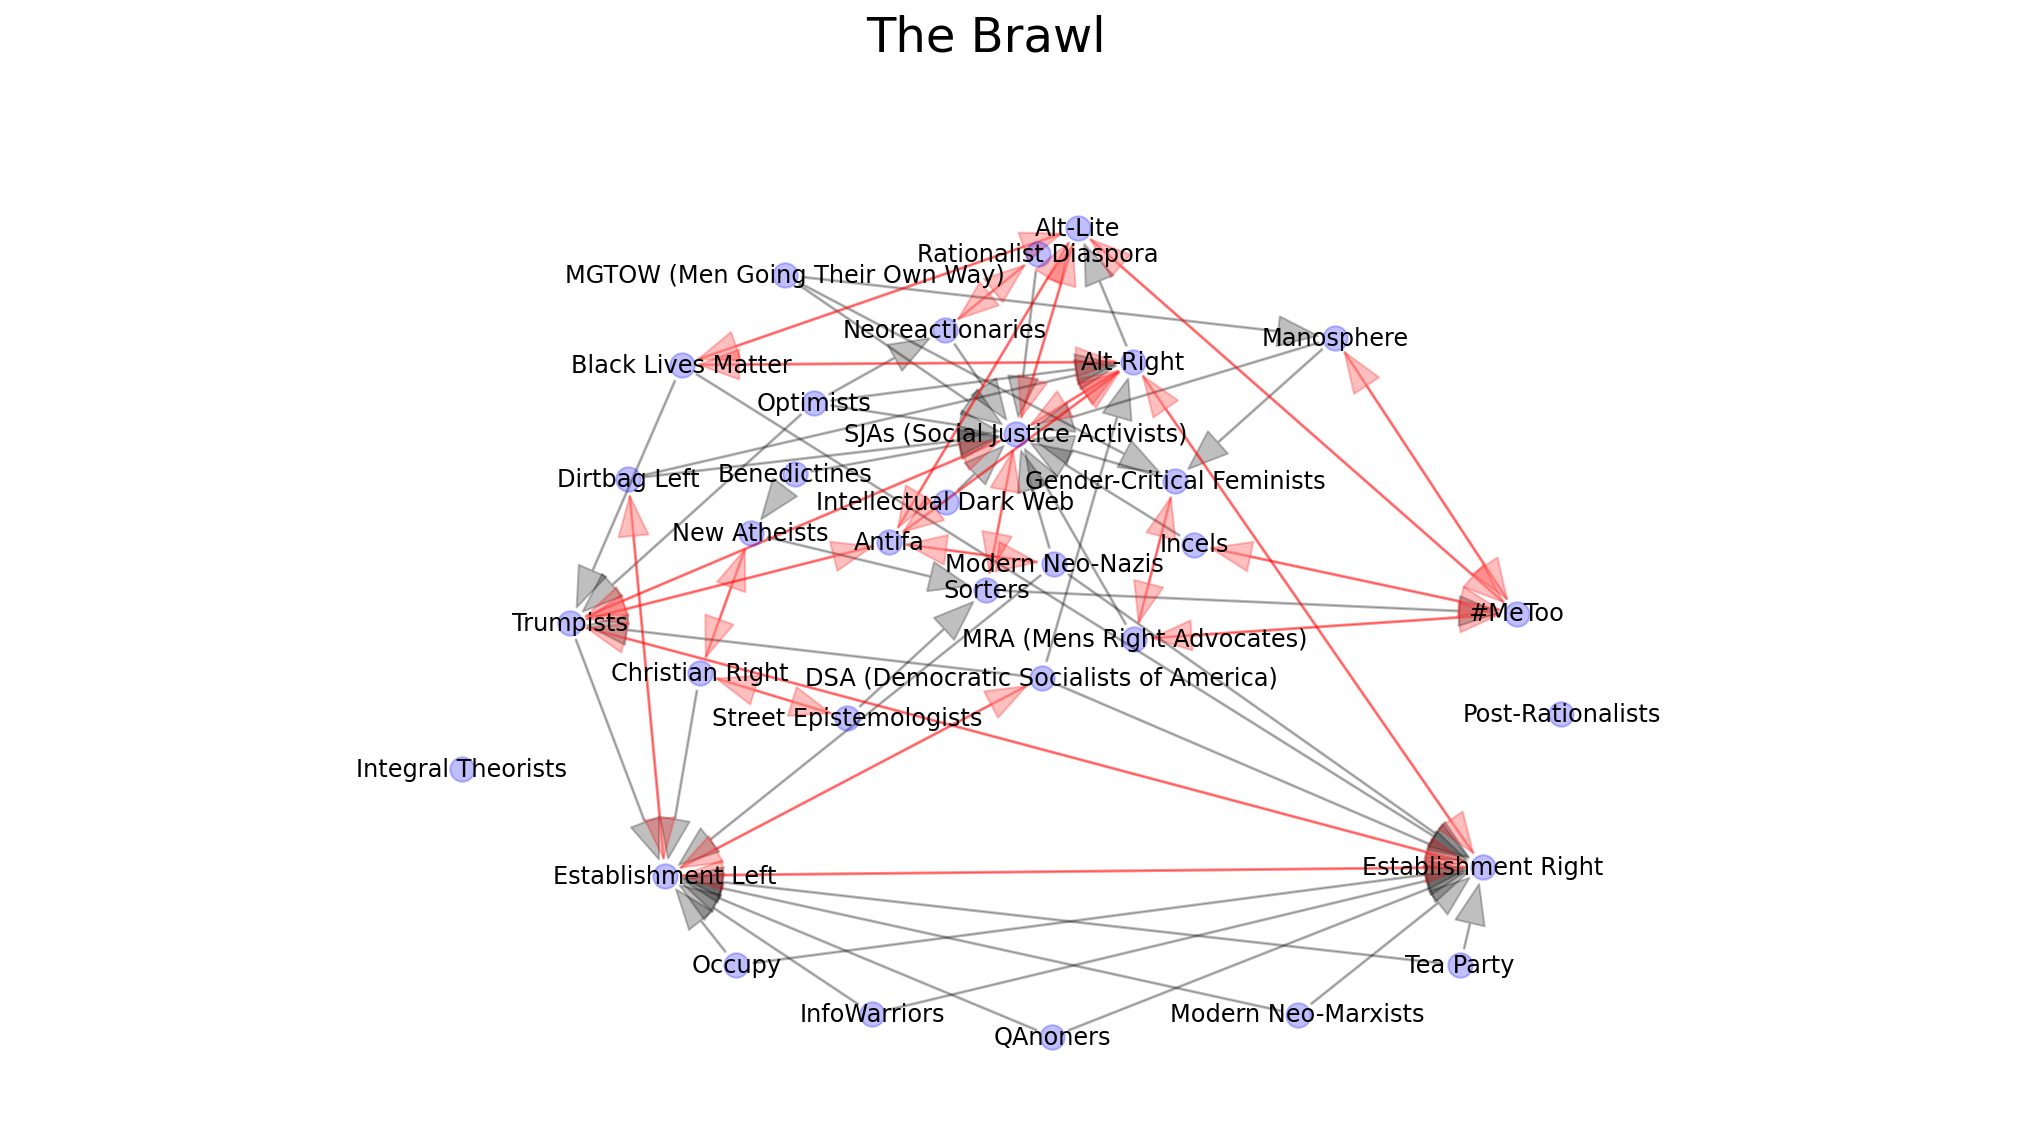

In [10]:

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

# Use the following only if you are on a high definition device
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

%matplotlib inline

# Draw the graph using the gephi layout
tribal_fig = plt.figure(figsize=(18, 9))
ax = tribal_fig.add_subplot(111)
plt.axis('off')
plt.xticks([], [])
plt.yticks([], [])
tribal_fig.suptitle('The Brawl', fontsize=24)

# Make fat arrows
arrowstyle = mpatches.ArrowStyle.Simple(head_length=2., head_width=1.5, tail_width=0.05)

# Make the nodes blue so you can make the double edges red
node_collection = nx.draw_networkx_nodes(G=tribes_digraph, pos=tribes_layout_dict, alpha=0.25,
                                         node_color='b', node_size=150)

# Get the double-edged edge list in red
edge_collection = nx.draw_networkx_edges(G=tribes_digraph, pos=tribes_layout_dict, alpha=0.25,
                                         arrowstyle=arrowstyle, edgelist=single_edge_list)
edge_collection = nx.draw_networkx_edges(G=tribes_digraph, pos=tribes_layout_dict, alpha=0.25,
                                         arrowstyle=arrowstyle, edgelist=double_edge_list,
                                         edge_color='r')

labels_collection = nx.draw_networkx_labels(G=tribes_digraph, pos=tribes_layout_dict, font_size=12)
axes_subplot = tribal_fig.get_axes()[0]
xlim_tuple = axes_subplot.set_xlim(left=-1500, right=1500)


----
### A look at some network characteristics

In [11]:

for key, value in dict(tribes_digraph.adj).items():
    print(f'{key}: {list(dict(value).keys())}')

SJAs (Social Justice Activists): ['Alt-Lite', 'Alt-Right', 'Sorters', 'Trumpists']
Black Lives Matter: ['Alt-Lite', 'Alt-Right', 'Trumpists', 'Establishment Right']
#MeToo: ['Alt-Lite', 'MRA (Mens Right Advocates)', 'Manosphere', 'Incels']
Gender-Critical Feminists: ['SJAs (Social Justice Activists)', 'MRA (Mens Right Advocates)']
Modern Neo-Marxists: ['Establishment Left', 'Establishment Right']
Antifa: ['Alt-Right', 'Alt-Lite', 'Modern Neo-Nazis', 'Trumpists']
Occupy: ['Establishment Left', 'Establishment Right']
Dirtbag Left: ['SJAs (Social Justice Activists)', 'Alt-Right', 'Establishment Left']
DSA (Democratic Socialists of America): ['Establishment Left', 'Establishment Right', 'Trumpists', 'Alt-Right']
Establishment Left: ['Establishment Right', 'DSA (Democratic Socialists of America)', 'Dirtbag Left']
Optimists: ['Trumpists', 'Neoreactionaries', 'Alt-Right', 'SJAs (Social Justice Activists)']
New Atheists: ['Christian Right', 'Sorters']
Street Epistemologists: ['Christian Right'

In [12]:

for item in sorted([f'{key}: {value}' for key, value in nx.square_clustering(tribes_digraph).items()],
                   key=lambda x: float(x.split(' ')[-1]), reverse=True):
    print(item)

Benedictines: 1.0
#MeToo: 0.6363636363636364
Establishment Left: 0.5714285714285714
Optimists: 0.5
Antifa: 0.4782608695652174
Black Lives Matter: 0.4
DSA (Democratic Socialists of America): 0.4
Modern Neo-Nazis: 0.35
SJAs (Social Justice Activists): 0.2857142857142857
Alt-Right: 0.2647058823529412
Manosphere: 0.2222222222222222
Sorters: 0.2
Christian Right: 0.2
Incels: 0.2
Trumpists: 0.18181818181818182
Alt-Lite: 0.16666666666666666
MGTOW (Men Going Their Own Way): 0.16666666666666666
Dirtbag Left: 0.15384615384615385
Establishment Right: 0.1111111111111111
MRA (Mens Right Advocates): 0.09090909090909091
Gender-Critical Feminists: 0.0
Modern Neo-Marxists: 0.0
Occupy: 0.0
New Atheists: 0.0
Street Epistemologists: 0.0
Rationalist Diaspora: 0.0
Post-Rationalists: 0
Integral Theorists: 0
Intellectual Dark Web: 0
Tea Party: 0.0
InfoWarriors: 0.0
QAnoners: 0.0
Neoreactionaries: 0.0


In [13]:

nx.average_clustering(tribes_digraph)

0.2870407465348815

In [14]:

for item in sorted([f'{key}: {value}' for key, value in nx.clustering(tribes_digraph).items()],
                   key=lambda x: float(x.split(' ')[-1]), reverse=True):
    print(item)

Modern Neo-Marxists: 1.0
Occupy: 1.0
Tea Party: 1.0
InfoWarriors: 1.0
QAnoners: 1.0
DSA (Democratic Socialists of America): 0.5555555555555556
Rationalist Diaspora: 0.5
MGTOW (Men Going Their Own Way): 0.5
Optimists: 0.4166666666666667
Black Lives Matter: 0.38461538461538464
Neoreactionaries: 0.3
Gender-Critical Feminists: 0.2777777777777778
Dirtbag Left: 0.2
Alt-Lite: 0.1875
Alt-Right: 0.1774193548387097
Establishment Right: 0.17045454545454544
Manosphere: 0.16666666666666666
Trumpists: 0.14285714285714285
Establishment Left: 0.125
MRA (Mens Right Advocates): 0.125
Modern Neo-Nazis: 0.1111111111111111
Antifa: 0.08333333333333333
SJAs (Social Justice Activists): 0.04838709677419355
#MeToo: 0
New Atheists: 0
Street Epistemologists: 0
Post-Rationalists: 0
Integral Theorists: 0
Sorters: 0
Intellectual Dark Web: 0
Benedictines: 0
Christian Right: 0
Incels: 0



----
#### Mental Models

In [15]:

mental_model_set = set()
for key, value in tribes_df['MENTAL MODELS'].to_dict().items():
    mental_models_list = value.split(', ')
    for mental_model in mental_models_list:
        mental_model_set.add(mental_model)
    print(f'{key}: {value}')

SJAs (Social Justice Activists): Essentialism, Normativity, Intersectionality
Black Lives Matter: Black Bodies, Reparations, Cultural Appropriations
#MeToo: Toxic Masculinity, Rape Culture, Pay Gap
Gender-Critical Feminists: Rapid-Onset Gender Dysphoria, Womyn-born Womyn
Modern Neo-Marxists: Hauntology, Capitalist Realism, Spectre of Ideology
Antifa: Direct Action, Diversity of Tactics, No Platforming
Occupy: The 99%, Culture Jamming, Crony Capitalism
Dirtbag Left: The Ratio, Milkshake Duck, Tankie
DSA (Democratic Socialists of America): Social dividend, Calculation in kind, Cooperative
Establishment Left: Welfare state, Pro-choice, Gun Control
Optimists: Skepticism, Scientific Method
New Atheists: Spectrum of Theistic Probability, Logical Fallacies
Street Epistemologists: Doxastic Openness/Closure​, Socratic Method, Aporia
Rationalist Diaspora: Bayes Theorem, Effective Altrusim, Cognitive Biases
Post-Rationalists: Weirding, Meaningness, Gervais Principle
Integral Theorists: AQAL, Spir

In [21]:

import itertools

COMPARISON_LIST = list(itertools.combinations(mental_model_set, 2))

In [22]:

COMPARISON_DICT = {}

In [23]:

import random

COMPARISON_TUPLE = random.choice(COMPARISON_LIST)
while COMPARISON_TUPLE in COMPARISON_DICT:
    COMPARISON_TUPLE = random.choice(COMPARISON_LIST)

In [149]:

import ipywidgets as widgets
from IPython.display import display
from ipywidgets import Button, Layout

left_button = widgets.Button(description=COMPARISON_TUPLE[0], layout=Layout(width='100%'))
right_button = widgets.Button(description=COMPARISON_TUPLE[1], layout=Layout(width='100%'))
output = widgets.Output()

display(left_button, right_button, output)
with output:
    print('Which mental model is more understandable to you?')

def on_button_clicked(b):
    COMPARISON_DICT[(left_button.description, right_button.description)] = b.description
    comparison_tuple = random.choice(COMPARISON_LIST)
    while comparison_tuple in COMPARISON_DICT:
        comparison_tuple = random.choice(COMPARISON_LIST)
    left_button.description = comparison_tuple[0]
    right_button.description = comparison_tuple[1]

left_button.on_click(on_button_clicked)
right_button.on_click(on_button_clicked)

Button(description='Normativity', layout=Layout(width='100%'), style=ButtonStyle())

Button(description='Meaningness', layout=Layout(width='100%'), style=ButtonStyle())

Output()

In [171]:

len(COMPARISON_DICT), len(COMPARISON_LIST)

(129, 4278)

In [172]:

nodes_set = set()
for comparison_tuple in COMPARISON_DICT.keys():
    nodes_set.add(comparison_tuple[0])
    nodes_set.add(comparison_tuple[1])

In [173]:

mental_models_digraph = nx.DiGraph()
mental_models_digraph.add_nodes_from(nodes_set)

In [174]:

for u_tuple, v in COMPARISON_DICT.items():
    for u in u_tuple:
        if u != v:
            mental_models_digraph.add_edge(u, v)
            break

In [175]:

centrality_dict = nx.in_degree_centrality(mental_models_digraph)
tribe_scores_dict = {}
for tribe_name, value in tribes_df['MENTAL MODELS'].to_dict().items():
    mental_models_list = value.split(', ')
    for mental_model in mental_models_list:
        tribe_scores_dict[tribe_name] = tribe_scores_dict.get(tribe_name, 0) + centrality_dict.get(mental_model, 0)
sorted([f'{key}: {value}' for key, value in tribe_scores_dict.items()],
       key=lambda x: float(x.split(' ')[-1]), reverse=True)

['Sorters: 0.13636363636363635',
 'Christian Right: 0.10227272727272728',
 'Antifa: 0.09090909090909091',
 'Optimists: 0.07954545454545454',
 '#MeToo: 0.06818181818181818',
 'Occupy: 0.06818181818181818',
 'Alt-Lite: 0.06818181818181818',
 'SJAs (Social Justice Activists): 0.05681818181818182',
 'InfoWarriors: 0.05681818181818182',
 'Intellectual Dark Web: 0.056818181818181816',
 'Neoreactionaries: 0.056818181818181816',
 'Gender-Critical Feminists: 0.045454545454545456',
 'Establishment Left: 0.045454545454545456',
 'Rationalist Diaspora: 0.045454545454545456',
 'Tea Party: 0.045454545454545456',
 'Trumpists: 0.045454545454545456',
 'MRA (Mens Right Advocates): 0.045454545454545456',
 'Manosphere: 0.045454545454545456',
 'MGTOW (Men Going Their Own Way): 0.045454545454545456',
 'New Atheists: 0.03409090909090909',
 'Street Epistemologists: 0.03409090909090909',
 'Benedictines: 0.03409090909090909',
 'Incels: 0.03409090909090909',
 'DSA (Democratic Socialists of America): 0.02272727272


----

In [165]:

tribes_df['FOREBEARS'].to_dict()

{'SJAs (Social Justice Activists)': 'Judith Butler, Kimberle Crenshaw, New Left',
 'Black Lives Matter': 'Audre Lorde, Franz Fanon, Malcolm X',
 '#MeToo': 'Second and Third Wave Feminists',
 'Gender-Critical Feminists': 'Janice Raymond',
 'Modern Neo-Marxists': 'Marxism, Situationist International, Frankfurt School',
 'Antifa': 'Anti-Racist Action, Antifaschistische Aktion',
 'Occupy': 'Adbusters, Arab Spring',
 'Dirtbag Left': 'Bernie Bros',
 'DSA (Democratic Socialists of America)': 'Michael Harrington, Jeremy Corbyn, Bernie Bros',
 'Establishment Left': 'Jimmy Carter, MLK, JFK',
 'Optimists': 'UN',
 'New Atheists': 'Bertrand Russell, Charles Darwin',
 'Street Epistemologists': 'Richard Dawkins, Sam Harris',
 'Rationalist Diaspora': 'Thomas Bayes, I. J. Good',
 'Post-Rationalists': 'James Carse, George Lakoff, Keith Johnstone',
 'Integral Theorists': 'Sri Aurobindo, Pierre Teilhard de Chardin',
 'Sorters': 'Carl Jung, Aleksandr Solzhenitsyn, Jean Piaget',
 'Intellectual Dark Web': 'H

In [166]:

sacred_dict = tribes_df['SACRED VALUES'].to_dict()

values_dict = {column_name: [key for key, value in sacred_dict.items() if column_name in value] for column_name,
               column_value in pd.Series(', '.join(sacred_dict.values()).split(', ')).value_counts().iteritems()}

In [167]:

sacred_dict

{'SJAs (Social Justice Activists)': 'Social Justice',
 'Black Lives Matter': 'Restorative Justice',
 '#MeToo': 'Empowerment, Social Justice',
 'Gender-Critical Feminists': 'Gender Equality',
 'Modern Neo-Marxists': 'Class Consciousness',
 'Antifa': 'Freedom (from fascism)',
 'Occupy': 'Economic Justice',
 'Dirtbag Left': 'Economic Justice, Progress',
 'DSA (Democratic Socialists of America)': 'Economic Justice, Progress',
 'Establishment Left': 'Equality, Progress',
 'Optimists': 'Reason, Science, Progress',
 'New Atheists': 'Objectivity, Secularity, Freethought',
 'Street Epistemologists': 'Objectivity, Doxastic Openess',
 'Rationalist Diaspora': 'Rationality',
 'Post-Rationalists': 'Insight, Interestingness',
 'Integral Theorists': 'Wisdom, Holism',
 'Sorters': 'Free Speech, Responsibility, Truth',
 'Intellectual Dark Web': 'Free Speech, Viewpoint Diversity, Intellectual Humility',
 'Benedictines': 'Christian Faith',
 'Christian Right': 'Christian Nationalism, Christian Faith',
 'Est

In [168]:

values_dict

{'Progress': ['Dirtbag Left',
  'DSA (Democratic Socialists of America)',
  'Establishment Left',
  'Optimists'],
 'Free Speech': ['Sorters', 'Intellectual Dark Web', 'Alt-Lite'],
 'Economic Justice': ['Occupy',
  'Dirtbag Left',
  'DSA (Democratic Socialists of America)'],
 'Social Justice': ['SJAs (Social Justice Activists)', '#MeToo'],
 'Gender Equality': ['Gender-Critical Feminists',
  'MRA (Mens Right Advocates)'],
 'Christian Faith': ['Benedictines', 'Christian Right'],
 'Objectivity': ['New Atheists', 'Street Epistemologists'],
 'White Ethnic Survival': ['Alt-Right', 'Modern Neo-Nazis'],
 'Viewpoint Diversity': ['Intellectual Dark Web'],
 'Fiscal Responsibility': ['Tea Party'],
 'Truth': ['Sorters'],
 'Reason': ['Optimists'],
 'Restorative Justice': ['Black Lives Matter'],
 'Rationality': ['Rationalist Diaspora'],
 'Freedom (from government)': ['Tea Party'],
 'Sexual Retribution': ['Incels'],
 'Natural Order': ['Neoreactionaries'],
 'Holism': ['Integral Theorists'],
 'Science': 


----
#### Make some Venn diagrams of the Sacred Values

In [169]:

import sys

!{sys.executable} -m pip install --upgrade matplotlib_venn --quiet

In [170]:

from matplotlib import pyplot as plt
import numpy as np
from matplotlib_venn import venn3, venn3_circles

In [73]:

tuples_list = sorted(values_dict.items(), key=lambda kv: len(kv[1]), reverse=True)
def show_values_venn(triples_list):
    subset_list = [set(t[1]) for t in triples_list]
    labels_list = tuple('\n'.join(t[0].split(' ')) for t in triples_list)
    venn_diagram = venn3(subsets=subset_list, set_labels=labels_list)
    circle_list = venn3_circles(subsets=subset_list)
    title_text = plt.title('Sacred Values Venn diagram')
    
    return circle_list, venn_diagram

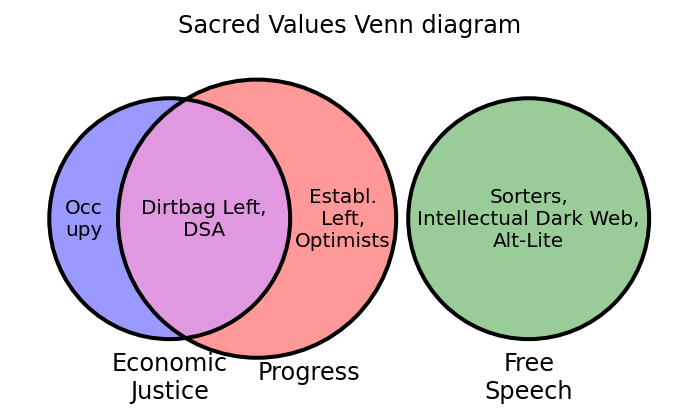

In [98]:

triples_list = tuples_list[:3]
circle_list, venn_diagram = show_values_venn(triples_list)
venn_diagram.get_label_by_id('100').set_text('Establ.\nLeft,\nOptimists')
venn_diagram.get_label_by_id('001').set_text('Occ\nupy')
venn_diagram.get_label_by_id('101').set_text('Dirtbag Left,\nDSA')
venn_diagram.get_label_by_id('010').set_text('Sorters,\nIntellectual Dark Web,\nAlt-Lite')
venn_diagram.get_label_by_id('A').set_position((-0.00968294436421356, -0.4051804571871522))

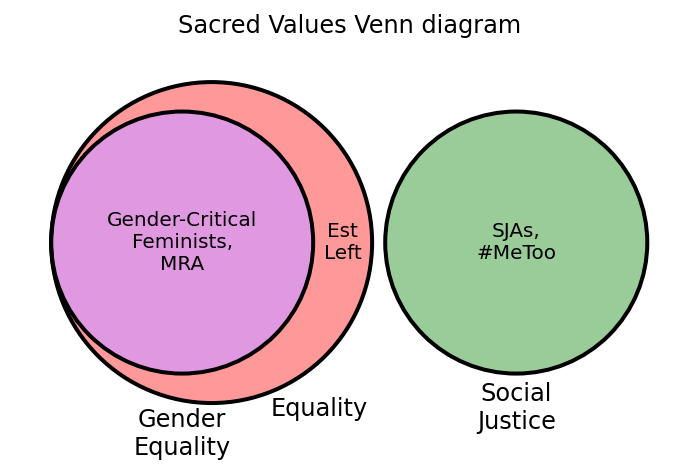

In [121]:

triples_list = tuples_list[3:6]
circle_list, venn_diagram = show_values_venn(triples_list)
venn_diagram.get_label_by_id('100').set_text('Est\nLeft')
venn_diagram.get_label_by_id('101').set_text('Gender-Critical\nFeminists,\nMRA')
venn_diagram.get_label_by_id('010').set_text('SJAs,\n#MeToo')
venn_diagram.get_label_by_id('C').set_position((-0.2943608715160385, -0.45))
venn_diagram.get_label_by_id('A').set_position((0.07968294436421356, -0.42))
venn_diagram.get_label_by_id('B').set_position((0.6154603552806802, -0.38))

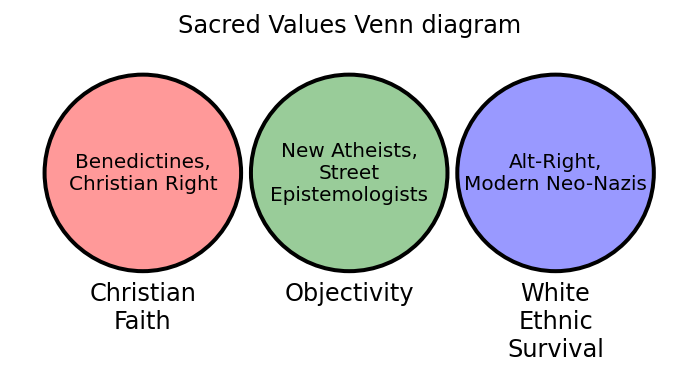

In [127]:

triples_list = tuples_list[6:9]
circle_list, venn_diagram = show_values_venn(triples_list)
venn_diagram.get_label_by_id('001').set_text('Alt-Right,\nModern Neo-Nazis')
venn_diagram.get_label_by_id('010').set_text('New Atheists,\nStreet\nEpistemologists')
venn_diagram.get_label_by_id('100').set_text('Benedictines,\nChristian Right')
venn_diagram.get_label_by_id('A').set_position((-0.6840435166640879, -0.35830850872880793))
venn_diagram.get_label_by_id('B').set_position((0.0, -0.35830850872880793))
venn_diagram.get_label_by_id('C').set_position((0.6840435166640879, -0.35830850872880793))

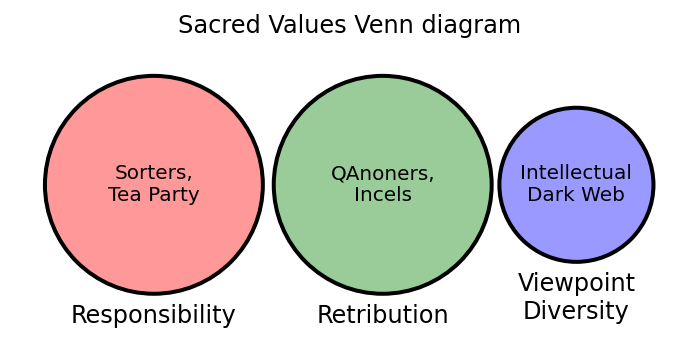

In [148]:

triples_list = tuples_list[9:12]
circle_list, venn_diagram = show_values_venn(triples_list)
venn_diagram.get_label_by_id('010').set_text('QAnoners,\nIncels')
venn_diagram.get_label_by_id('100').set_text('Sorters,\nTea Party')
venn_diagram.get_label_by_id('001').set_text('Intellectual\nDark Web')
venn_diagram.get_label_by_id('A').set_position((-0.5764731574010526, -0.389023586519325))
venn_diagram.get_label_by_id('B').set_position((0.17285897138311124, -0.389023586519325))
venn_diagram.get_label_by_id('C').set_position((0.807228372035883, -0.2845120154907868))